In [1]:
from google.colab import drive 
drive.mount('/content/drive')

%cd /content/drive/My\ Drive/Colab Notebooks

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks


In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from IPython import display

from matplotlib import pyplot as plt
import numpy as np

import os
import imageio

In [3]:
IMG_SIZE = (128,128)
BATCH_SIZE = 32
EPOCHS = 40
D_LR = 1.2e-4
G_LR = 3e-4
LATENT_DIM = 128
LATENT_STEPS = 100
DATA_DIR = 'met_images'
num_examples_to_generate = 9

SEED = tf.random.normal([num_examples_to_generate, LATENT_DIM])
WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
tf.get_logger().setLevel('ERROR')

In [4]:
#load data, batch data, resize
ds = tf.keras.utils.image_dataset_from_directory(DATA_DIR,
                                                 label_mode=None,
                                                 color_mode='rgb',
                                                 image_size=IMG_SIZE,
                                                 batch_size=BATCH_SIZE)

Found 1336 files belonging to 1 classes.


In [5]:
flip = tf.keras.layers.RandomFlip('horizontal')
rotate = tf.keras.layers.RandomRotation(0.05)
zoom = tf.keras.layers.RandomZoom(0.5)
brightness = tf.keras.layers.RandomBrightness(0.7)
translation = tf.keras.layers.RandomTranslation((-.08,.08),(-.08,.08),
                                                interpolation='bilinear')
add_gaussian_noise = tf.keras.layers.GaussianNoise(stddev=0.1)
#augment sequence
aug = tf.keras.Sequential([flip,
                           #rotate,
                           zoom,
                           #brightness,
                           #translation,
                           add_gaussian_noise
                           ])

#augment original set 
combined_ds = ds
for i in range(0,10):
    aug_ds = ds.map(lambda x: aug(x))
    combined_ds = combined_ds.concatenate(aug_ds)

rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)
ds = combined_ds.map(lambda x: rescale(x))

In [6]:
def make_generator_model():
    model = tf.keras.Sequential()
    
    model.add(layers.Dense(8*8*512, input_shape=(LATENT_DIM,)))    
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.ReLU())  
    
    model.add(layers.Reshape((8,8,512)))
    
    model.add(layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding='same', kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(0.2))
    
    model.add(layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding='same', kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(0.2))
    
    model.add(layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(0.2))
    
    #3 color channels rgb
    model.add(layers.Conv2DTranspose(3, kernel_size=4, padding='same'))
    model.add(layers.Activation("tanh"))
    
    return model

generator = make_generator_model()
#generator.summary()

In [7]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    
    model.add(layers.Conv2D(32, kernel_size=4, strides=2, padding='same',
                            input_shape=(128,128,3)))
    #model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    #model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(64, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    #model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    #model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(256, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))

    #model.add(layers.Dropout(0.25))
    #model.add(layers.Conv2D(256, kernel_size=4, strides=2, padding='same'))
    #model.add(layers.BatchNormalization(momentum=0.8))
    #model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

discriminator = make_discriminator_model()
#discriminator.summary()

In [8]:
class DCGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):

        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Step 1. Train the discriminator with both real images (label as 1) and fake images (classified as label as 0) 
        with tf.GradientTape() as tape:
            # Compute discriminator loss on real images
            pred_real = self.discriminator(real_images, training=True)
            real_labels = tf.ones((batch_size, 1))
            # UPDATED: apply one-sided label smoothing to real labels
            real_labels += 0.05 * tf.random.uniform(tf.shape(real_labels)) 
            d_loss_real = self.loss_fn(real_labels, pred_real)

            # Compute discriminator loss on fake images
            fake_images = self.generator(noise)
            pred_fake = self.discriminator(fake_images, training=True)
            fake_labels = tf.zeros((batch_size, 1))
            # UPDATED: add random noise to fake labels - not needed
            # fake_labels += 0.05 * tf.random.uniform(tf.shape(fake_labels)) 
            d_loss_fake = self.loss_fn(fake_labels, pred_fake)

            # total discriminator loss
            d_loss = (d_loss_real + d_loss_fake)/2
        # Compute discriminator gradients
        grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        # Update discriminator weights
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_variables))

        # Step 2. Train the generator (do not update weights of the discriminator)
        misleading_labels = tf.ones((batch_size, 1)) # G wants D to think the fake images are real (label as 1)

        with tf.GradientTape() as tape:
            fake_images = self.generator(noise, training=True)
            pred_fake = self.discriminator(fake_images, training=True)
            g_loss = self.loss_fn(misleading_labels, pred_fake)
        # Compute generator gradients
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update generator weights
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

In [9]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

        # Create random noise seed for visualization during traing
        self.seed = tf.random.normal([9, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.model.generator(self.seed)
        generated_images = (generated_images *.5) +.5
        generated_images.numpy()

        display.clear_output(wait=True)
        fig = plt.figure(figsize=(10, 10))
        for i in range(self.num_img):
            plt.subplot(3, 3, i+1)
            img = keras.utils.array_to_img(generated_images[i]) 
            plt.imshow(img)
            plt.axis('off')
        plt.savefig('epoch_{:04d}.png'.format(epoch)) 
        plt.show()

    def on_train_end(self, logs=None):
        self.model.generator.save('generator.h5')

In [10]:
dcgan = DCGAN(discriminator=discriminator, generator=generator, latent_dim=LATENT_DIM)

In [11]:
dcgan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=D_LR, beta_1 = 0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=G_LR, beta_1 = 0.5),  
    loss_fn=keras.losses.BinaryCrossentropy(),
)

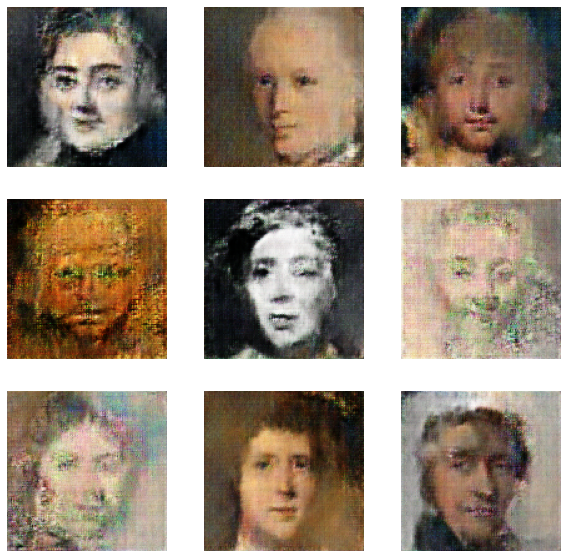

462/462 [==============================] - 76s 161ms/step - d_loss: 0.5253 - g_loss: 1.1010


In [12]:
dcgan.fit(ds, epochs=EPOCHS, callbacks=[GANMonitor(num_img=9, latent_dim=LATENT_DIM)])

In [13]:
def create_gif():
    with imageio.get_writer('met_gan_2.gif', mode='i') as writer:
        for epoch in range(1,EPOCHS):
            im = imageio.imread('epoch_{:04d}.png'.format(epoch))
            for j in range(0,6):
              writer.append_data(im)

create_gif()

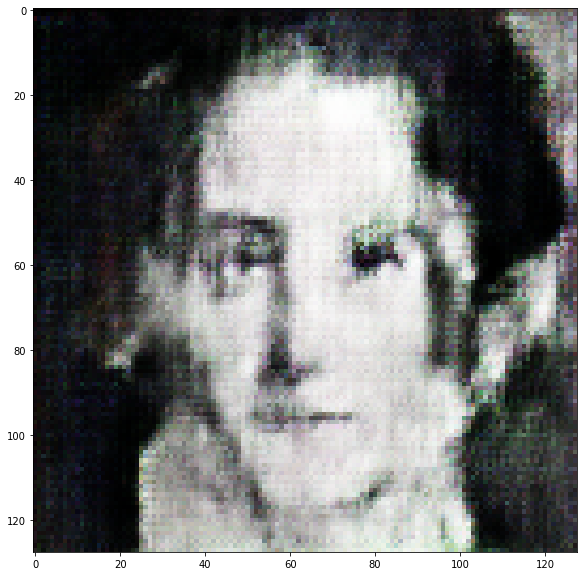

In [14]:
seed = tf.random.normal([1,LATENT_DIM])
new_seed = seed
latent_step = tf.random.normal([1,LATENT_DIM], stddev=0.2)

fig = plt.figure(figsize=(10, 10))
for i in range(0,LATENT_STEPS):
  display.clear_output(wait=True)

  new_seed = new_seed + latent_step
                                 
  gen_im = generator(new_seed, training=False)
  plt.imshow(gen_im[0,:,:,:]*.5+.5)
  plt.savefig('latent_walk_{:04d}.png'.format(i))

In [15]:
def create_walk_gif():
    with imageio.get_writer('met_gan_latent_walk.gif', mode='i') as writer:
        for i in range(1,LATENT_STEPS):
            im = imageio.imread('latent_walk_{:04d}.png'.format(i))
            for j in range(0,6):
              writer.append_data(im)

create_walk_gif()